# Introduction

This notebook presents each of the example problems in the official [FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/ftut1.html), but in their super friendly pyironized format. For a description of the underlying physics/mathematics, please see the official documentation. The purpose here is as a rosetta stone to demonstrate the translation into pyiron.

At the moment it's also really a testbed so that I (Liam huber@mpie.de) can play around with our interface class(es) to see what is necessary and helpful across a broad selection of problems. These are also codified as integration tests to ensure nothing gets broken during development.

In [1]:
%load_ext autoreload
%autoreload 2
from pyiron_continuum import Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr = Project('fenics_tutorial')
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/3 [00:00<?, ?it/s]

# Fundamentals: Solving the Poisson equation

In [3]:
job = pr.create.job.Fenics('poisson', delete_existing_job=True)

/home/muhammad/workspace/gitRepo/pyiron-repos/replicate_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:127: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


In [4]:
job.domain.mesh.unit.square(8,8)

In [5]:
job.domain.boundary(bc_type='Dirichlet', expression='1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

In [6]:
job.solver.lhs = 'dot(grad(u), grad(v)) * dx'
job.solver.rhs = 'Constant(-6.0) * v * dx'

In [7]:
job.run()

The job poisson was saved and received the ID: 41
Solving linear variational problem.


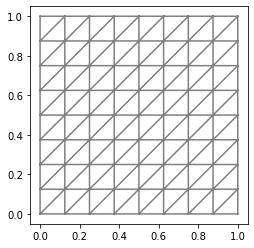

In [8]:
job.plot.mesh()

In [9]:
job.output.solution

[array([1.      , 1.015625, 1.0625  , 1.140625, 1.25    , 1.390625,
        1.5625  , 1.765625, 2.      , 1.03125 , 1.046875, 1.09375 ,
        1.171875, 1.28125 , 1.421875, 1.59375 , 1.796875, 2.03125 ,
        1.125   , 1.140625, 1.1875  , 1.265625, 1.375   , 1.515625,
        1.6875  , 1.890625, 2.125   , 1.28125 , 1.296875, 1.34375 ,
        1.421875, 1.53125 , 1.671875, 1.84375 , 2.046875, 2.28125 ,
        1.5     , 1.515625, 1.5625  , 1.640625, 1.75    , 1.890625,
        2.0625  , 2.265625, 2.5     , 1.78125 , 1.796875, 1.84375 ,
        1.921875, 2.03125 , 2.171875, 2.34375 , 2.546875, 2.78125 ,
        2.125   , 2.140625, 2.1875  , 2.265625, 2.375   , 2.515625,
        2.6875  , 2.890625, 3.125   , 2.53125 , 2.546875, 2.59375 ,
        2.671875, 2.78125 , 2.921875, 3.09375 , 3.296875, 3.53125 ,
        3.      , 3.015625, 3.0625  , 3.140625, 3.25    , 3.390625,
        3.5625  , 3.765625, 4.      ])]

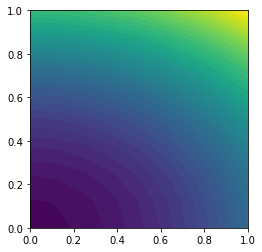

In [10]:
job.plot.solution()

In [11]:
u_D = job.solver.expression(expression='1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

In [13]:
error_L2 = job.solver.error_norm(u_D)

vertex_values_u_D = u_D.compute_vertex_values(job.mesh)
vertex_values_u = job.output.solution[-1]

print('error_L2  =', error_L2)
print('error_max =', np.max(np.abs(vertex_values_u_D - vertex_values_u)))
      
# Try increasing the element order to 3 and the mesh resolution to see the error drop

error_L2  = 0.008235098073354827*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.

error_max = 1.3322676295501878e-15


# Deflection of a membrane

In [14]:
job = pr.create.job.Fenics('membrane', delete_existing_job=True)
job.input.mesh_resolution = 64
job.input.element_order = 2

/home/muhammad/workspace/gitRepo/pyiron-repos/replicate_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:127: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


In [15]:
job.domain.mesh.circle((0, 0), 1)

In [16]:
job.domain.mesh()

In [17]:
job.domain.boundary(bc_type='Dirichlet', constant=0)

In [18]:
job.solver.lhs = 'dot(grad(u), grad(v)) * dx'

In [21]:
job.solver.set_expression(key='p', expression='4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))', degree=1, beta=8, R0=0.6)

In [22]:
job.solver.rhs = 'p * v * dx'

In [23]:
job.run()

The job membrane was saved and received the ID: 42
Solving linear variational problem.


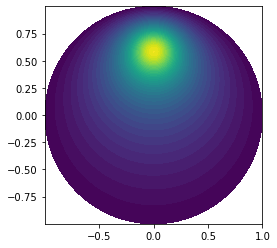

In [24]:
job.plot.solution()

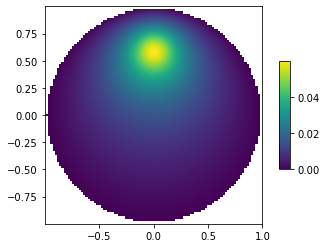

In [25]:
job.plot.solution2d(n_grid=100);  # Our simple output plotter also works for non-square mesh-shapes
# Here we drop the interpolation parameter to see the coarse-grained-ness

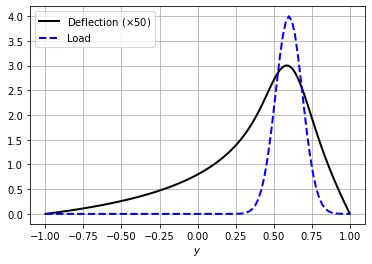

In [26]:
p = job.solver.expression(expression='4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))', degree=1, beta=8, R0=0.6)
tol = 0.001  # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]  # 2D points cutting a vertical line through the center of the domain
w_line = np.array([job.solver.solution(point) for point in points])
p_line = np.array([p(point) for point in points])

plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left');

# The heat equation

In [72]:
job = pr.create.job.Fenics('heat', delete_existing_job=True)
job.input.n_steps = 10
job.input.dt = 2.0 / job.input.n_steps

In [73]:
job.domain.mesh.unit.square(8,8)

In [74]:
u_D = job.solver.expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=3, beta=1.2, t=0)

In [75]:
job.domain.boundary(bc_type='Dirichlet', expression=u_D)

In [76]:
job.solver.set_initial_condition(expression=u_D)

The intial value will be assigned to 'u_n'!


In [77]:
job.solver.set_expression(key='f', constant='u_D.beta - 2 - 2*u_D.alpha', u_D=u_D)

In [80]:
job.solver.F = 'u * v * dx + dt * dot(grad(u), grad(v)) * dx - (u_n + dt * f) * v * dx'

In [81]:
job.solver.time_dependent_expressions.append(u_D)
job.solver.assigned_u = job.solver.u_n

In [82]:
job.run()

The job heat was saved and received the ID: 43
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


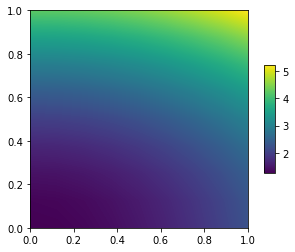

In [83]:
job.plot.solution2d(frame=0);

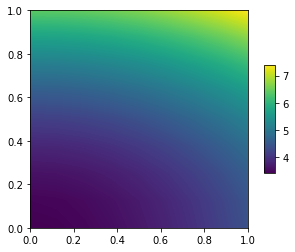

In [84]:
job.plot.solution2d(frame=-1);

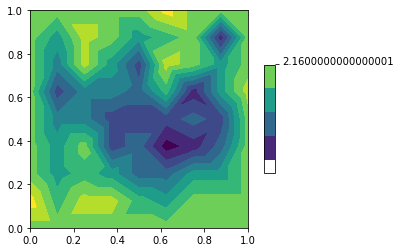

In [85]:
job.plot.nodal2d(nodal_values=job.output.solution[-1] - job.output.solution[0]);

# Diffusion of a Gaussian function

In [86]:
job = pr.create.job.Fenics('gauss', delete_existing_job=True)
job.input.n_steps = 50
job.input.dt = 2.0 / job.input.n_steps

/home/muhammad/workspace/gitRepo/pyiron-repos/replicate_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:127: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


In [87]:
job.domain.mesh.regular.rectangle((-2, -2), (2, 2), 30, 30)

In [88]:
job.domain.boundary(bc_type='Dirichlet', constant=0)

In [89]:
job.solver.set_initial_condition(expression='exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', degree=2, a=5)

The intial value will be assigned to 'u_n'!


In [90]:
job.solver.set_expression(key='f', constant='0')

In [91]:
job.solver.F = 'u * v * dx + dt * dot(grad(u), grad(v)) * dx - (u_n + dt * f) * v * dx'
job.solver.assigned_u = job.solver.u_n

In [92]:
job.run()

The job gauss was saved and received the ID: 44
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear v

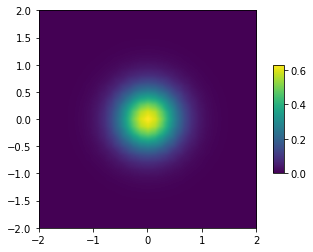

In [93]:
job.plot.solution2d(frame=0);

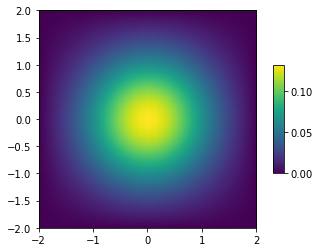

In [94]:
job.plot.solution2d(frame=8);

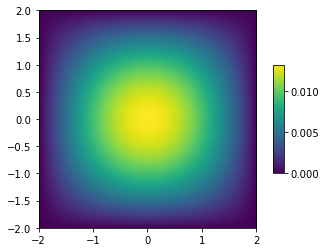

In [95]:
job.plot.solution2d(frame=-1);

# Nonlinear Poisson

In [96]:
job = pr.create.job.Fenics('poisson_nonlinear', delete_existing_job=True)

/home/muhammad/workspace/gitRepo/pyiron-repos/replicate_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:127: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


In [97]:
def q(u):
    """Return nonlinear coefficient"""
    return 1 + u**2

In [98]:
x, y = job.sympy.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - job.sympy.diff(q(u) * job.sympy.diff(u, x), x) - job.sympy.diff(q(u) * job.sympy.diff(u, y), y)
f = job.sympy.simplify(f)
u_code = job.sympy.printing.ccode(u)
f_code = job.sympy.printing.ccode(f)

In [99]:
job.domain.mesh.unit.square(8,8)

In [100]:
u_D = job.solver.expression(u_code, degree=1)
job.domain.boundary(bc_type='Dirichlet', expression=u_D)

In [101]:
job.solver.f = job.solver.expression(f_code, degree=1)

In [102]:
job.solver.set_extra_func(func_key='q', func=q)

In [103]:
job.solver.u = job.solver.solution
job.solver.lhs = 'q(u) * dot(grad(u), grad(v)) * dx - f * v * dx'
job.solver.rhs = 0

In [104]:
job.run()

The job poisson_nonlinear was saved and received the ID: 45
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.533e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.614e+01 (tol = 1.000e-10) r (rel) = 5.767e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.883e+01 (tol = 1.000e-10) r (rel) = 1.739e+00 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.293e+01 (tol = 1.000e-10) r (rel) = 5.058e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 4.990e+00 (tol = 1.000e-10) r (rel) = 1.101e-01 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.970e-01 (tol = 1.000e-10) r (rel) = 8.758e-03 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.964e-03 (tol = 1.000e-10) r (rel) = 6.539e-05 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 1.272e-07 (tol = 1.000e-10) r (rel) = 2.806e-09 (tol = 1.000e-

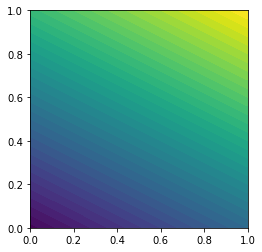

In [105]:
job.plot.solution()

# Linear Elasticity

In [106]:
L = 1
W = 0.2
K = 1.9167
G = 1
rho = 1
delta = W / L
gamma = 0.4 * delta ** 2

job = pr.create.job.FenicsLinearElastic('linear_elasticity', delete_existing_job=True)
job.input.bulk_modulus = K
job.input.shear_modulus = G
job.domain.mesh.regular.box((0, 0, 0), (L, W, W), 10, 3, 3)

/home/muhammad/workspace/gitRepo/pyiron-repos/replicate_continuum/notebooks/pyiron_continuum/fenics/job/generic.py:127: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


In [107]:
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < 1e-14

job.domain.boundary(bc_type='dirichlet', constant=(0.,0.,0.), bc_func=clamped_boundary)

In [108]:
job.solver.set_expression(key='f', constant=(0, 0, -rho*gamma))
job.solver.set_expression(key='T', constant=(0, 0, 0))

In [109]:
job.run()

The job linear_elasticity was saved and received the ID: 46
Solving linear variational problem.


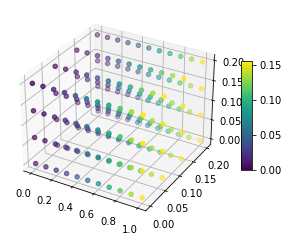

In [110]:
job.plot.solution3d();

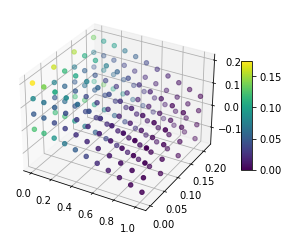

In [111]:
# von Mises stress is saved in the output
job.plot.stress3d();

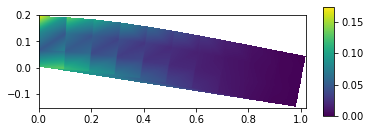

In [112]:
job.plot.stress2d(projection_axis=1);